In [285]:
from caffe2.python import workspace, brew, optimizer
from caffe2.python.model_helper import ModelHelper

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# net visualization
from caffe2.python import net_drawer
from IPython import display

In [286]:
# Iris plants dataset
iris = datasets.load_iris()

In [287]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [288]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [289]:
workspace.ResetWorkspace()

True

In [290]:
X = iris_df.drop(['target'], axis=1)
y = iris_df['target']

In [291]:
X.shape

(149, 4)

In [292]:
# convert dataframe into array and reshape them
X = np.asarray(X)
y = np.asarray(y)

In [293]:
X.shape

(149, 4)

In [294]:
X = np.reshape(X, (-1,1))
y = np.reshape(y, (-1,1))
print('shape x:', X.shape)
print('shape y:',y.shape)
np.testing.assert_equal(X.shape[0],y.shape[0]*4) # there are 4 features

shape x: (596, 1)
shape y: (149, 1)


In [295]:
# this dataset is already in numpy array 
data, labels = shuffle(iris.data, iris.target)

In [296]:
data = data.astype(np.float32)
labels = labels.astype(np.int32)

In [297]:
workspace.FeedBlob('data', data)
workspace.FeedBlob('labels', labels)

True

In [298]:
# sample data
data[4:8]

array([[6. , 2.2, 4. , 1. ],
       [5.1, 3.3, 1.7, 0.5],
       [5.3, 3.7, 1.5, 0.2],
       [6.2, 2.9, 4.3, 1.3]], dtype=float32)

In [299]:
# sample data
labels[4:10]

array([1, 0, 0, 1, 2, 1], dtype=int32)

In [300]:
workspace.Blobs()

['data', 'labels']

In [301]:
model = ModelHelper(name='model_X')

In [302]:
model

In [303]:
# first layer - fully connected 1
fc1 = brew.fc(model, 'data', 'fc1', dim_in=4, dim_out=50)

In [304]:
# activation
relu = brew.relu(model, 'fc1', 'relu1')

In [305]:
# second layer - fully connected 2
fc2 = brew.fc(model, 'relu1', 'fc2', dim_in=50, dim_out=3)

In [306]:
softmax, loss = model.net.SoftmaxWithLoss([fc2, 'labels'], ['softmax', 'loss'])

In [307]:
model.net.Proto()

name: "model_X_7"
op {
  input: "data"
  input: "fc1_w"
  input: "fc1_b"
  output: "fc1"
  name: ""
  type: "FC"
  arg {
    name: "order"
    s: "NCHW"
  }
  arg {
    name: "use_cudnn"
    i: 1
  }
  arg {
    name: "cudnn_exhaustive_search"
    i: 0
  }
}
op {
  input: "fc1"
  output: "relu1"
  name: ""
  type: "Relu"
  arg {
    name: "order"
    s: "NCHW"
  }
  arg {
    name: "cudnn_exhaustive_search"
    i: 0
  }
  engine: "CUDNN"
}
op {
  input: "relu1"
  input: "fc2_w"
  input: "fc2_b"
  output: "fc2"
  name: ""
  type: "FC"
  arg {
    name: "order"
    s: "NCHW"
  }
  arg {
    name: "use_cudnn"
    i: 1
  }
  arg {
    name: "cudnn_exhaustive_search"
    i: 0
  }
}
op {
  input: "fc2"
  input: "labels"
  output: "softmax"
  output: "loss"
  name: ""
  type: "SoftmaxWithLoss"
}
external_input: "data"
external_input: "fc1_w"
external_input: "fc1_b"
external_input: "fc2_w"
external_input: "fc2_b"
external_input: "labels"

In [308]:
model.params

[BlobReference("fc1_w"),
 BlobReference("fc1_b"),
 BlobReference("fc2_w"),
 BlobReference("fc2_b")]

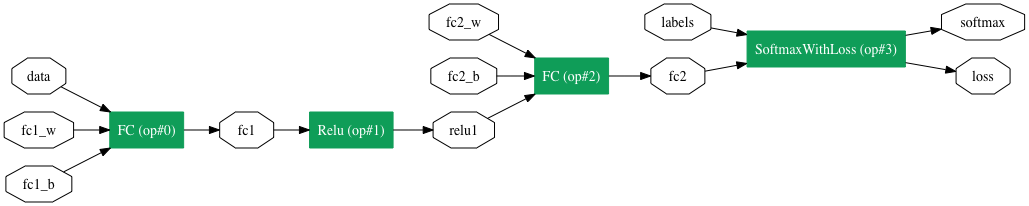

In [309]:
# LR = network layout: Left to Right
graph = net_drawer.GetPydotGraph(model, rankdir="LR")
display.Image(graph.create_png(), width=1200)

In [310]:
model.AddGradientOperators([loss])

{BlobReference("loss"): BlobReference("loss_autogen_grad"),
 BlobReference("fc2"): BlobReference("fc2_grad"),
 BlobReference("relu1"): BlobReference("relu1_grad"),
 BlobReference("fc2_w"): BlobReference("fc2_w_grad"),
 BlobReference("fc2_b"): BlobReference("fc2_b_grad"),
 BlobReference("fc1"): BlobReference("fc1_grad"),
 BlobReference("data"): BlobReference("data_grad"),
 BlobReference("fc1_w"): BlobReference("fc1_w_grad"),
 BlobReference("fc1_b"): BlobReference("fc1_b_grad")}

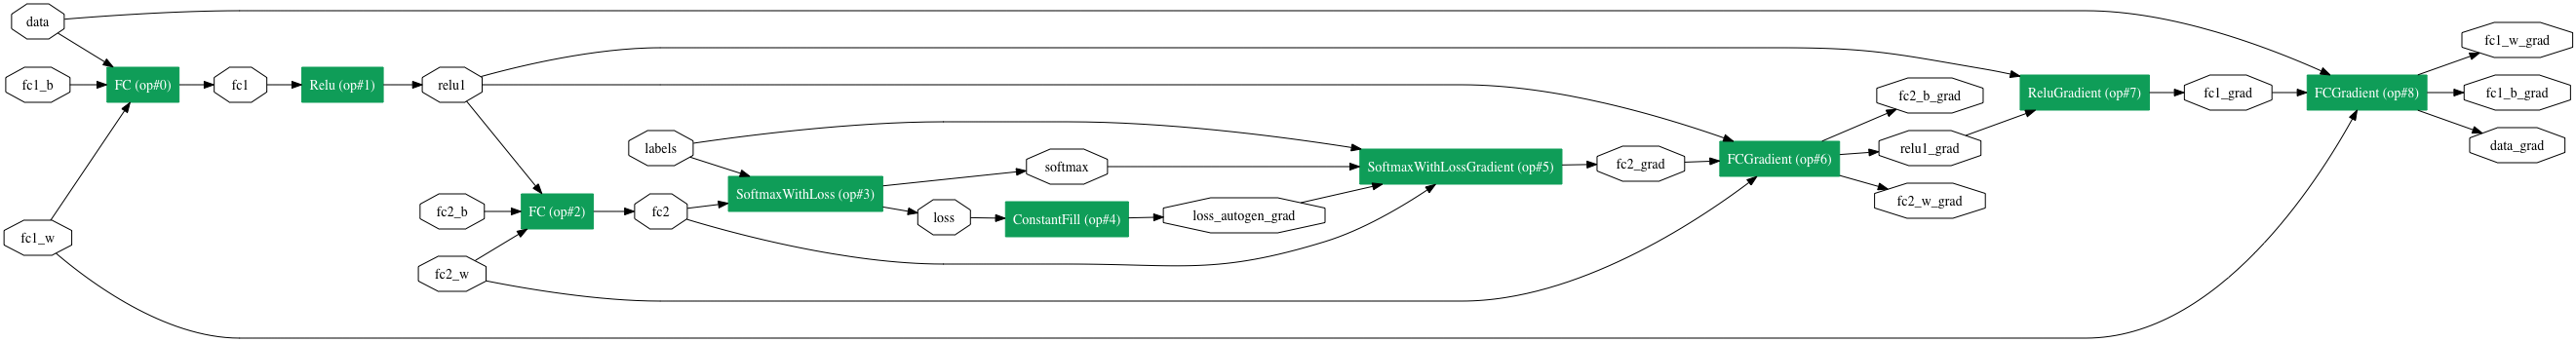

In [311]:
# It's now more complicated because our net has gradient now
graph = net_drawer.GetPydotGraph(model, rankdir="LR")
display.Image(graph.create_png(), width=1200)

In [312]:
optimizer.build_sgd(model, base_learning_rate=0.01)

In [313]:
# initialize model parameters
workspace.RunNetOnce(model.param_init_net)

True

In [314]:
workspace.CreateNet(model.net)

True

In [315]:
for i in range(1000):
    workspace.RunNet(model.net)
    
    if i % 100 == 0:
        print('iteration {}, loss is {} '.format(i, np.round(workspace.FetchBlob('loss'),2)))

iteration 0, loss is 1.090000033378601 
iteration 100, loss is 0.4000000059604645 
iteration 200, loss is 0.3100000023841858 
iteration 300, loss is 0.25 
iteration 400, loss is 0.2199999988079071 
iteration 500, loss is 0.1899999976158142 
iteration 600, loss is 0.17000000178813934 
iteration 700, loss is 0.1599999964237213 
iteration 800, loss is 0.15000000596046448 
iteration 900, loss is 0.14000000059604645 


In [316]:
# the output is probability from the softmax layer
predicted = workspace.FetchBlob('softmax')
predicted[:6]

array([[5.8206199e-03, 7.6500189e-01, 2.2917745e-01],
       [1.9776069e-03, 3.4564686e-01, 6.5237558e-01],
       [1.7650222e-05, 8.0666691e-02, 9.1931564e-01],
       [1.8606517e-03, 6.8732059e-01, 3.1081870e-01],
       [3.7427344e-03, 9.5597237e-01, 4.0284898e-02],
       [9.7146648e-01, 2.8531929e-02, 1.6261813e-06]], dtype=float32)

In [317]:
predicted.shape

(150, 3)

In [318]:
# to see the predicted values
np.argmax(predicted, axis=1)

array([1, 2, 2, 1, 1, 0, 0, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1,
       2, 1, 2, 2, 1, 0, 0, 2, 0, 0, 1, 2, 0, 2, 1, 1, 1, 0, 0, 2, 0, 0,
       2, 2, 1, 0, 1, 0, 2, 0, 2, 0, 0, 2, 1, 2, 2, 2, 0, 0, 0, 2, 0, 2,
       2, 0, 1, 0, 0, 0, 1, 0, 2, 1, 0, 1, 1, 0, 2, 2, 0, 2, 1, 2, 2, 2,
       2, 1, 0, 2, 1, 1, 0, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0,
       2, 2, 0, 0, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, 2, 0, 2, 0, 1, 0, 0,
       1, 0, 1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0])

In [319]:
# here are the actual labels
labels

array([1, 2, 2, 1, 1, 0, 0, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1,
       2, 1, 2, 2, 1, 0, 0, 1, 0, 0, 1, 2, 0, 2, 1, 1, 1, 0, 0, 2, 0, 0,
       2, 2, 1, 0, 1, 0, 2, 0, 2, 0, 0, 2, 1, 2, 2, 2, 0, 0, 0, 1, 0, 2,
       2, 0, 1, 0, 0, 0, 1, 0, 2, 1, 0, 1, 1, 0, 2, 2, 0, 2, 1, 2, 2, 2,
       2, 1, 0, 2, 1, 1, 0, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0,
       2, 2, 0, 0, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, 2, 0, 2, 0, 1, 0, 0,
       1, 0, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0], dtype=int32)

In [320]:
np.equal(np.argmax(predicted, axis=1), labels)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [321]:
# calculate the accuracy
np.equal(np.argmax(predicted, axis=1), labels).sum() / len(labels)

0.98